#### This notebook trains our baseline model

Imports

In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
os.chdir("../models")
from model import CustomCNN
from common_utils import set_seed, EarlyStopper, train, get_mean_rgb, CustomTransform, CustomRegularizeTransform

import matplotlib.pyplot as plt

# set seed
set_seed(42)

Initialise model and dataset

In [2]:
model = CustomCNN(fcn_depth=3, fcn_width=[1024, 512]) # initialise model

transform1 = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((100, 100), antialias=True),
    transforms.ColorJitter(brightness=0.2, saturation=0.2),
    transforms.RandomHorizontalFlip(0.5),
    # most of the pictures are rotation invariant
    # transforms.RandomRotation((-30, 30)),
    transforms.RandomResizedCrop((100, 100), scale=(0.8, 1.0), antialias=True),
])

transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100, 100), antialias=True),
])

# load data
train_dataset = datasets.Flowers102(root='../data', split='test', download=True, transform=transform1) 
val_dataset = datasets.Flowers102(root='../data', split='val', download=True, transform=transform2) 
test_dataset = datasets.Flowers102(root='../data', split='train', download=True, transform=transform2)
# NOTE: Due to a bug with the Flowers102 dataset, the train and test splits are swapped

batch_size = 128
# initialise dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Visualize the original images and their transformed version

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


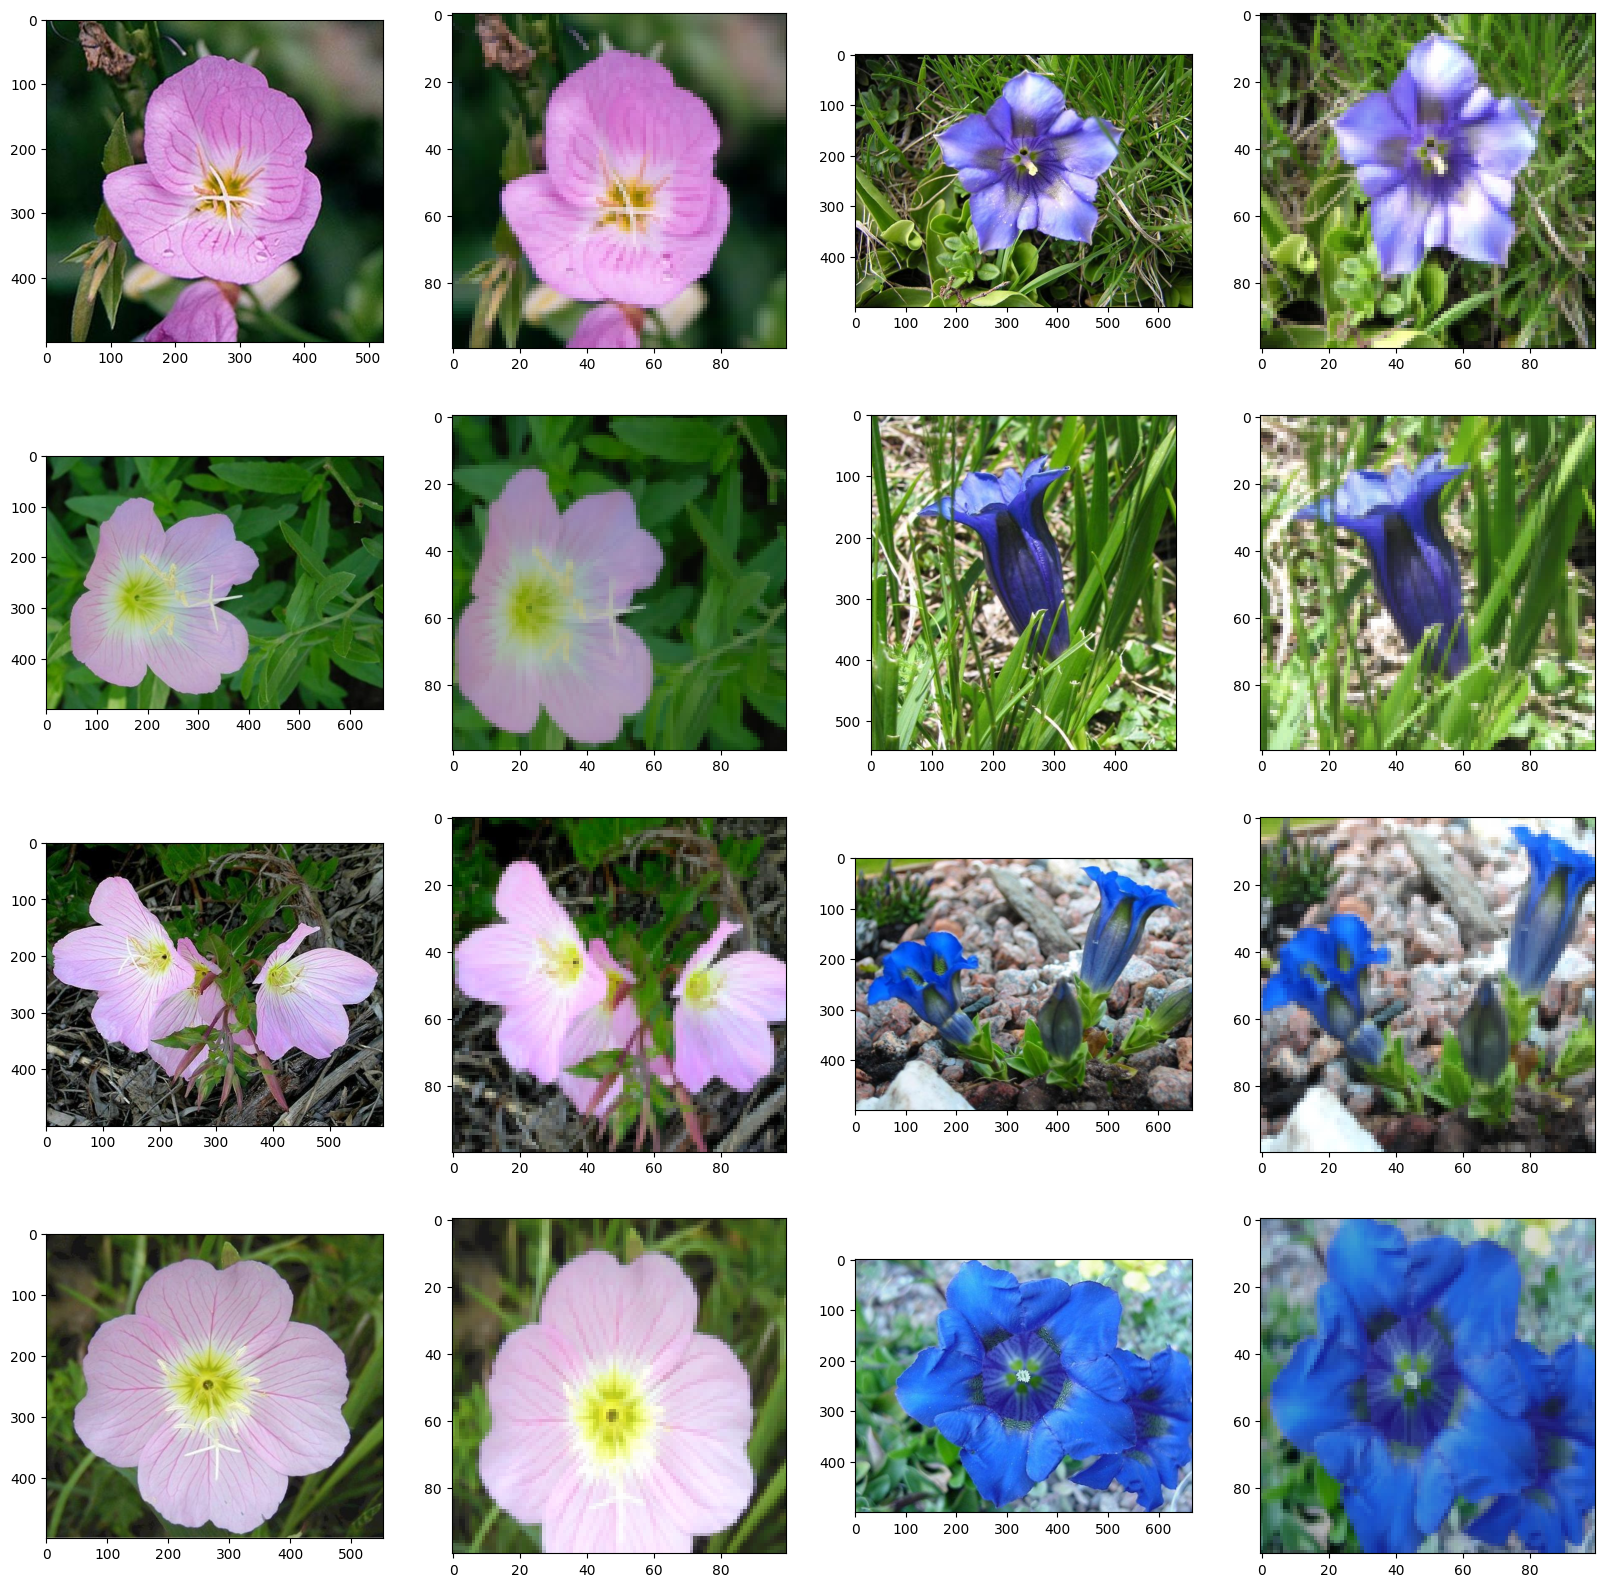

In [3]:
from itertools import product

train_dataset_ = datasets.Flowers102(root='../data', split='test', download=True, transform=transforms.ToTensor()) 

fig, axs = plt.subplots(4, 4, figsize=(20, 20))
offset = 1000 # Changet this to get different images

for i, j in product(range(4), range(2)):
    axs[i][2*j].imshow(train_dataset_[i+j*offset][0].permute(1, 2, 0))
    axs[i][2*j+1].imshow(train_dataset[i+j*offset][0].permute(1, 2, 0))

Specify hyperparameters

In [4]:
lr = 0.001 # learning rate
optimiser = torch.optim.Adam(model.parameters(), lr=lr) # initialise optimiser
loss = torch.nn.CrossEntropyLoss() # initialise loss function

if torch.cuda.is_available(): # nvidia gpu
    device = torch.device("cuda")
elif torch.backends.mps.is_available(): # apple gpu
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model.to(device)

epochs = 300 # number of epochs
early_stopper = EarlyStopper(patience=10) # initialise early stopper


# Make directory to save baseline model
baseline_model_path = "./saved_models/baseline_model/non_preprocessed"
if not os.path.exists(baseline_model_path):
    os.makedirs(baseline_model_path, exist_ok=True)

# Define the device-specific path
device_type = None
if device == torch.device("cuda"):
    device_type = "cuda"
elif device == torch.device("mps"):
    device_type = "mps"
else:
    device_type = "cpu"

# Construct the full path
device_path = os.path.join(baseline_model_path, device_type)

# Create the directory if it doesn't exist
if not os.path.exists(device_path):
    os.mkdir(device_path)

model

CustomCNN(
  (conv_stack): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=None, affine=True, track_running_stats=True)
    (1): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=3)
    (2): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (7): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=64)
    (8): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (9): ReLU()
    (10): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (11): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), gro

Train the model

In [5]:
train_loss_list, val_loss_list, val_acc_list = train(model, train_dataloader, val_dataloader, optimiser, loss, device, epochs, early_stopper, device_path) # train model

Epoch 1/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:15<00:00,  1.55s/it, Training loss=3.8846]


Epoch 1/300 took 81.35s | Train loss: 3.8846 | Val loss: 5.5469 | Val accuracy: 1.08% | EarlyStopper count: 0


Epoch 2/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:08<00:00,  1.40s/it, Training loss=3.0103]


Epoch 2/300 took 74.11s | Train loss: 3.0103 | Val loss: 3.8696 | Val accuracy: 7.84% | EarlyStopper count: 0


Epoch 3/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:09<00:00,  1.42s/it, Training loss=2.5994]


Epoch 3/300 took 75.03s | Train loss: 2.5994 | Val loss: 2.6380 | Val accuracy: 30.29% | EarlyStopper count: 0


Epoch 4/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:08<00:00,  1.40s/it, Training loss=2.2246]


Epoch 4/300 took 74.34s | Train loss: 2.2246 | Val loss: 2.2589 | Val accuracy: 38.43% | EarlyStopper count: 0


Epoch 5/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:10<00:00,  1.44s/it, Training loss=1.9123]


Epoch 5/300 took 75.71s | Train loss: 1.9123 | Val loss: 1.9894 | Val accuracy: 45.69% | EarlyStopper count: 0


Epoch 6/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:07<00:00,  1.38s/it, Training loss=1.7041]


Epoch 6/300 took 72.95s | Train loss: 1.7041 | Val loss: 1.9577 | Val accuracy: 46.18% | EarlyStopper count: 0


Epoch 7/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:08<00:00,  1.40s/it, Training loss=1.7560]


Epoch 7/300 took 74.07s | Train loss: 1.7560 | Val loss: 1.8028 | Val accuracy: 50.88% | EarlyStopper count: 0


Epoch 8/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:10<00:00,  1.44s/it, Training loss=1.6617]


Epoch 8/300 took 76.36s | Train loss: 1.6617 | Val loss: 1.7133 | Val accuracy: 52.94% | EarlyStopper count: 0


Epoch 9/300: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:09<00:00,  1.42s/it, Training loss=1.4605]


Epoch 9/300 took 74.72s | Train loss: 1.4605 | Val loss: 1.5310 | Val accuracy: 58.73% | EarlyStopper count: 0


Epoch 10/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:10<00:00,  1.44s/it, Training loss=1.2465]


Epoch 10/300 took 75.71s | Train loss: 1.2465 | Val loss: 1.4902 | Val accuracy: 58.53% | EarlyStopper count: 0


Epoch 11/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:08<00:00,  1.41s/it, Training loss=1.1492]


Epoch 11/300 took 74.57s | Train loss: 1.1492 | Val loss: 1.5532 | Val accuracy: 57.75% | EarlyStopper count: 0


Epoch 12/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:10<00:00,  1.43s/it, Training loss=1.2745]


Epoch 12/300 took 75.14s | Train loss: 1.2745 | Val loss: 1.4613 | Val accuracy: 59.51% | EarlyStopper count: 1


Epoch 13/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:09<00:00,  1.42s/it, Training loss=1.1421]


Epoch 13/300 took 75.02s | Train loss: 1.1421 | Val loss: 1.4620 | Val accuracy: 60.49% | EarlyStopper count: 0


Epoch 14/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:09<00:00,  1.43s/it, Training loss=1.0665]


Epoch 14/300 took 75.50s | Train loss: 1.0665 | Val loss: 1.2895 | Val accuracy: 62.94% | EarlyStopper count: 1


Epoch 15/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:08<00:00,  1.40s/it, Training loss=0.9873]


Epoch 15/300 took 73.94s | Train loss: 0.9873 | Val loss: 1.3931 | Val accuracy: 60.29% | EarlyStopper count: 0


Epoch 16/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:09<00:00,  1.42s/it, Training loss=1.1669]


Epoch 16/300 took 75.17s | Train loss: 1.1669 | Val loss: 1.5139 | Val accuracy: 57.25% | EarlyStopper count: 1


Epoch 17/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:08<00:00,  1.40s/it, Training loss=2.5775]


Epoch 17/300 took 74.03s | Train loss: 2.5775 | Val loss: 2.1404 | Val accuracy: 43.14% | EarlyStopper count: 2


Epoch 18/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:08<00:00,  1.41s/it, Training loss=1.8729]


Epoch 18/300 took 74.64s | Train loss: 1.8729 | Val loss: 1.7980 | Val accuracy: 50.00% | EarlyStopper count: 3


Epoch 19/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:09<00:00,  1.41s/it, Training loss=1.6499]


Epoch 19/300 took 74.49s | Train loss: 1.6499 | Val loss: 1.7116 | Val accuracy: 52.35% | EarlyStopper count: 4


Epoch 20/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:08<00:00,  1.40s/it, Training loss=1.4109]


Epoch 20/300 took 73.87s | Train loss: 1.4109 | Val loss: 1.8145 | Val accuracy: 51.27% | EarlyStopper count: 5


Epoch 21/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:09<00:00,  1.42s/it, Training loss=2.1386]


Epoch 21/300 took 75.39s | Train loss: 2.1386 | Val loss: 1.9303 | Val accuracy: 48.43% | EarlyStopper count: 6


Epoch 22/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:10<00:00,  1.44s/it, Training loss=1.9941]


Epoch 22/300 took 76.24s | Train loss: 1.9941 | Val loss: 1.8020 | Val accuracy: 50.00% | EarlyStopper count: 7


Epoch 23/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:10<00:00,  1.44s/it, Training loss=1.6577]


Epoch 23/300 took 75.95s | Train loss: 1.6577 | Val loss: 1.6794 | Val accuracy: 52.84% | EarlyStopper count: 8


Epoch 24/300: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:08<00:00,  1.40s/it, Training loss=1.4793]


Epoch 24/300 took 73.98s | Train loss: 1.4793 | Val loss: 1.5682 | Val accuracy: 57.06% | EarlyStopper count: 9
Early stopping


Plot train, test loss and test accuracy

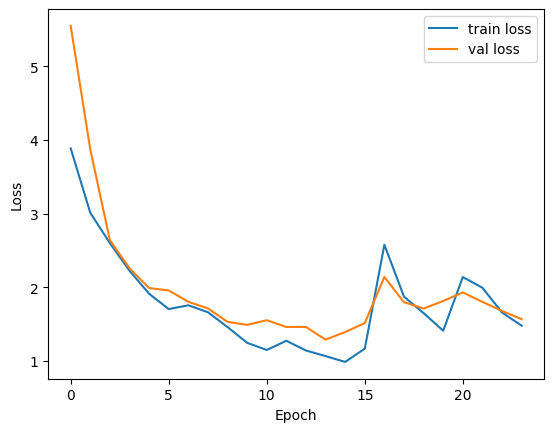

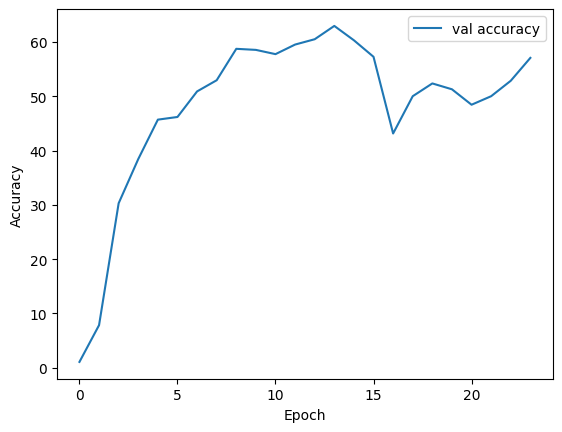

In [7]:
# plot the graphs
import matplotlib.pyplot as plt
plt.plot(train_loss_list, label="train loss")
plt.plot(val_loss_list, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(val_acc_list, label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()